# Exploratory Data Analysis for Kaggle's TalkingData AdTracking Fraud Detection Challenge

# Gustavo Bulhões Carvalho da Paz Freire

## Dataset

Iniciaremos nossa análise com o arquivo `train.csv`. Cada linha contém um click record, com as seguintes features:

- ip: ip address of click.
- app: app id for marketing.
- device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
- os: os version id of user mobile phone
- channel: channel id of mobile ad publisher
- click_time: timestamp of click (UTC)
- attributed_time: if user download the app for after clicking an ad, this is the time of the app download
- is_attributed: the target that is to be predicted, indicating the app was downloaded

## Explorando o Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 10)

col_types = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8'
        }

df = pd.read_csv("../input/train.csv", 
                 low_memory=True, 
                 dtype=col_types, 
                 parse_dates=['click_time'], 
                 infer_datetime_format=True,
                 usecols = lambda x: x not in "attributed_time")

In [2]:
df.head()

,ip,app,device,os,channel,click_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,0
1,17357,3,1,19,379,2017-11-06 14:33:34,0
2,35810,3,1,13,379,2017-11-06 14:34:12,0
3,45745,14,1,13,478,2017-11-06 14:34:52,0
4,161007,3,1,13,379,2017-11-06 14:35:08,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184903890 entries, 0 to 184903889
Data columns (total 7 columns):
ip               uint32
app              uint16
device           uint16
os               uint16
channel          uint16
click_time       datetime64[ns]
is_attributed    uint8
dtypes: datetime64[ns](1), uint16(4), uint32(1), uint8(1)
memory usage: 3.6 GB


In [4]:
df.describe()

,ip,app,device,os,channel,is_attributed
count,1.849039e+08,1.849039e+08,1.849039e+08,1.849039e+08,1.849039e+08,1.849039e+08
mean,9.087604e+04,1.201131e+01,2.172325e+01,2.267702e+01,2.685789e+02,2.470721e-03
std,6.952789e+04,1.480521e+01,2.593326e+02,5.525282e+01,1.295882e+02,4.964491e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.024500e+04,3.000000e+00,1.000000e+00,1.300000e+01,1.400000e+02,0.000000e+00
50%,7.962200e+04,1.200000e+01,1.000000e+00,1.800000e+01,2.580000e+02,0.000000e+00
75%,1.182470e+05,1.500000e+01,1.000000e+00,1.900000e+01,3.790000e+02,0.000000e+00
max,3.647780e+05,7.680000e+02,4.227000e+03,9.560000e+02,5.000000e+02,1.000000e+00


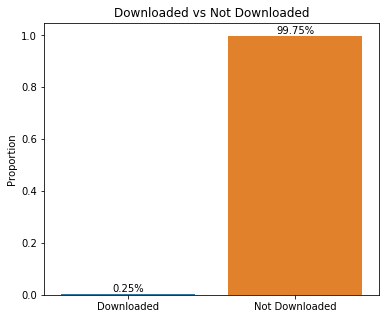

In [5]:
plt.figure(figsize=(6,5))
mean = (df.is_attributed.values == 1).mean()
ax = sns.barplot(['Downloaded', 'Not Downloaded'], [mean, 1-mean])
ax.set(ylabel='Proportion', title='Downloaded vs Not Downloaded')
for p, uniq in zip(ax.patches, [mean, 1-mean]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.01,
            '{}%'.format(round(uniq * 100, 2)),
            ha="center")

Note que a média de `is_attributed` é 0.00247, ou seja, apenas 0,25% dos clicks geram download, o que é um indício da presença de clicks fraudulentos.

## Unique Values

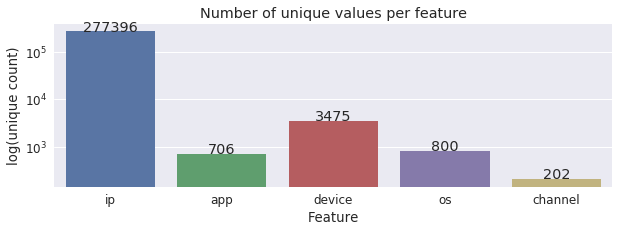

In [6]:
plt.figure(figsize=(10, 3))
cols = ['ip', 'app', 'device', 'os', 'channel']
uniques = [len(df[col].unique()) for col in cols]
sns.set(font_scale=1.2)
ax = sns.barplot(cols, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

O número de valores únicos de IP é muito maior do que o das outras features, ou seja, é a categoria mais fina que temos para diferenciar os clicks. 

Cumulative number of clicks and downloads in unique features:


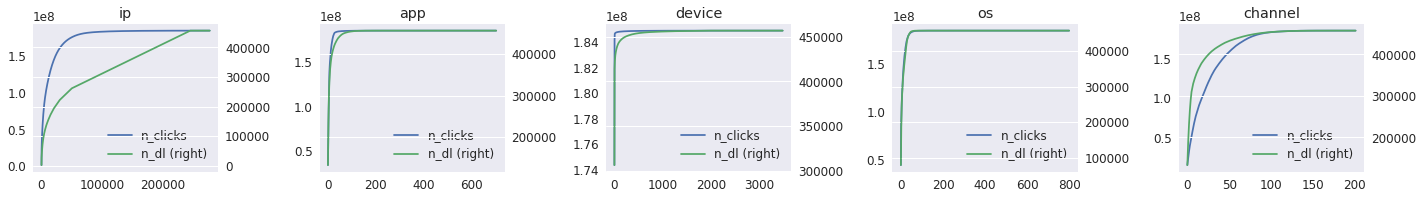

In [7]:
cols = ['ip', 'app', 'device', 'os', 'channel']

print("Cumulative number of clicks and downloads in unique features:")
plt.figure(figsize=(20,3))
for idx, col in enumerate(cols):
    plt.subplot(1,5,idx+1)
    plt.title(col)
    df[col].value_counts().cumsum().sort_values().reset_index(drop=True).plot(legend=True, label = 'n_clicks')
    df.groupby(col)['is_attributed'].agg('sum').sort_values(ascending=False).cumsum().reset_index(drop=True).plot(secondary_y=True, legend=True, label = 'n_dl')
    plt.tight_layout()

Podemos ver de forma geral que há poucos `ips`, `apps`, `devices` e `os` concentrando a maior parte dos clicks, enquanto que `channel` é menos concentrado nesse quesito. 
O número de downloads segue formato semelhante para `apps`, `devices` e `os`. Para `ip`, os downloads são menos concentrados que os clicks, havendo uma concentração no início e depois uma distribuição semelhante para os próximos `ips`, onde no fim temos `ips` sem downloads. Para `channel`, os downloads são mais concentrados que os clicks. 

Como as próximas operações demandam mais memória, vamos trabalhar a partir de agora com uma amostra aleatória de 20% da base inteira.

## Clicks e Downloads

In [8]:
df = df.sample(frac = 0.2)

Clicks and downloads by feature (%)


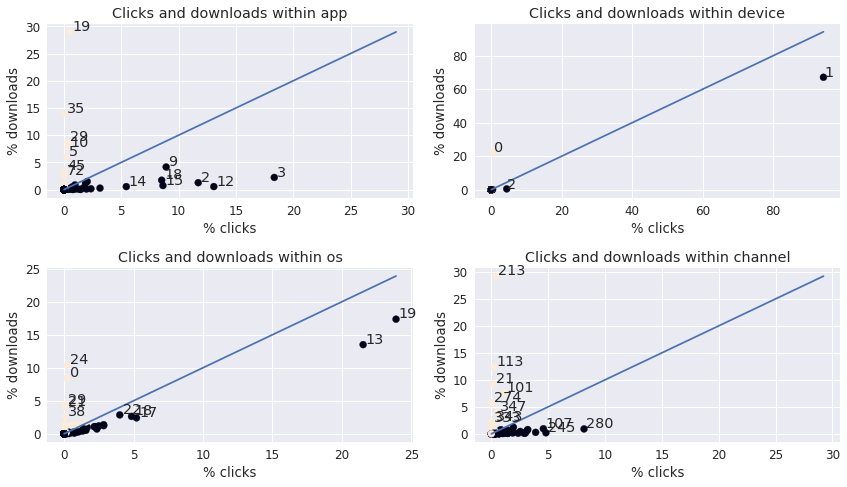

In [9]:
print("Clicks and downloads by feature (%)")

plt.figure(figsize=(12, 7))

cols = ['app', 'device', 'os', 'channel']

for idx, col in enumerate(cols):
    tbl = df.groupby(col)['is_attributed'].agg(['count', 'sum']).rename(columns={"count": "n_clicks", "sum": "n_dl"}).reset_index()
    tbl['click_pct'] = tbl['n_clicks'] / tbl['n_clicks'].sum() * 100
    tbl['dl_pct'] = tbl['n_dl'] / df['is_attributed'].sum() * 100
    tbl.sort_values(by=['n_clicks'], ascending=False).head(10)

    plt.subplot(2,2,idx+1)
    plt.scatter(tbl['click_pct'], tbl['dl_pct'], c = tbl['dl_pct'] > tbl['click_pct'])
    plt.plot( [0, tbl[['click_pct', 'dl_pct']].max().max()],[0,tbl[['click_pct', 'dl_pct']].max().max()] )

    for i in tbl.index[(tbl['click_pct']>4) | (tbl['dl_pct'] > 2)].tolist():
        plt.annotate(str(tbl.loc[i, col]), (tbl['click_pct'][i]+0.2, tbl['dl_pct'][i]+0.2))

    plt.title("Clicks and downloads within " + col)
    plt.xlabel("% clicks")
    plt.ylabel("% downloads")
    plt.tight_layout()

A reta de 45° nos gráficos seria onde clicks e downloads deveriam estar se fossem proporcionais. Quanto mais abaixo da reta os pontos estiverem, mais provável que representem clicks fraudulentos, pois temos uma grande porcentagem de clicks para uma baixa porcentagem de downloads, e de forma análoga os pontos acima da reta são mais propensos a serem clicks que geram download.
Por exemplo, no primeiro gráfico, o `app` 19 representa poucos clicks mas muitos downloads, então deveríamos acreditar que é provável que clicks nesse app gerem download. Com o `app` 3 ocorre exatamente o contrário.
Outro exemplo evidente é o `channel` 213, que representa poucos clicks e muitos downloads, e assim por diante.

## Click Counts e Download Rate por IP

Proportion Downloaded over Click Counts of most popular IPs
        ip  click_count  prop_downloaded
0     5348       247260         0.001840
1     5314       234209         0.001862
2    73516       154171         0.001336
3    73487       153482         0.001388
4    53454       100205         0.000319
..     ...          ...              ...
15  137052        43385         0.001314
16    5178        42548         0.002256
17  201182        42214         0.001303
18   49602        40150         0.001071
19    5147        39507         0.002101

[20 rows x 3 columns]


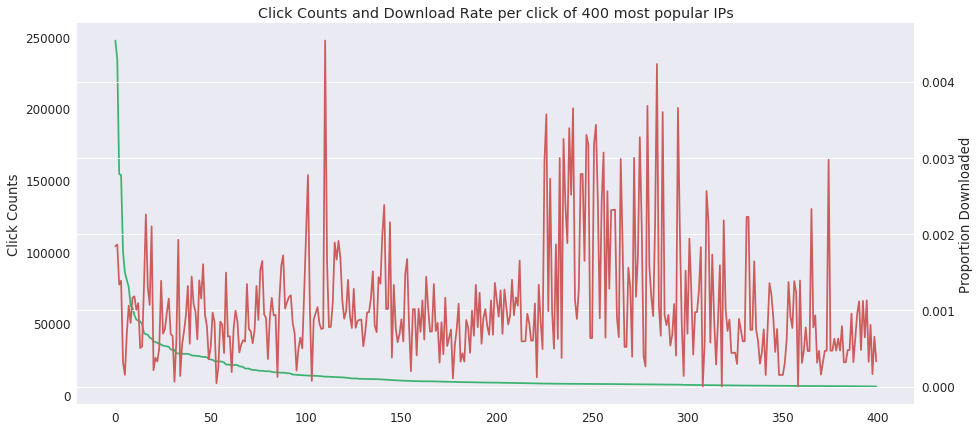

In [10]:
proportion = df[['ip', 'is_attributed']].groupby('ip', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = df[['ip', 'is_attributed']].groupby('ip', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='ip', how='left')
merge.columns = ['ip', 'click_count', 'prop_downloaded']

ax1 = merge.click_count[:400].plot(figsize = (15,7), color='mediumseagreen', legend = None)
ax2 = merge.prop_downloaded[:400].plot(color='indianred', secondary_y = True, legend=None)
ax1.set(title = 'Click Counts and Download Rate per click of 400 most popular IPs', 
       ylabel = 'Click Counts');
ax2.set(ylabel = 'Proportion Downloaded');

print('Proportion Downloaded over Click Counts of most popular IPs')
print(merge[:20])

Com este gráfico conseguimos ver que poucos `ips` são responsáveis por uma grande quantidade de clicks. Provavelmente são `ips` de lugares que compartilham sua rede com muitos usuários. Porém, a taxa de download por click não parece se relacionar com isso, apresentando muita variação.

## Click Counts e Download Rate por App

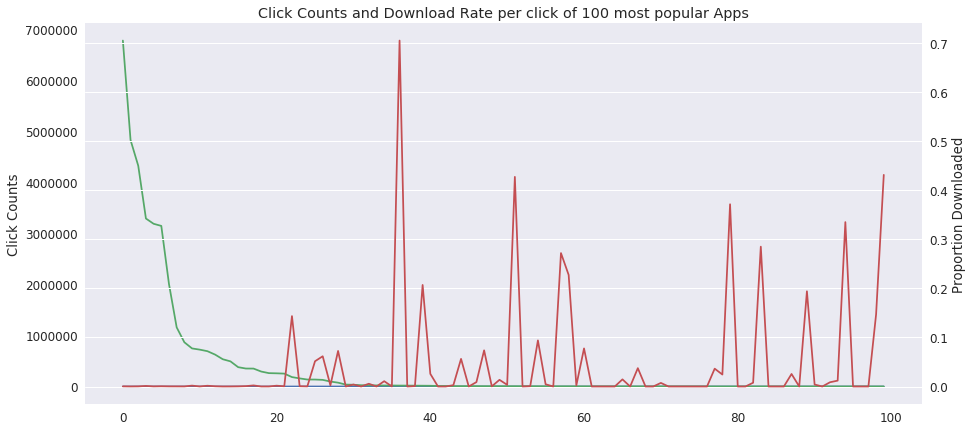

Proportion Downloaded over Click Counts of most popular Apps
    app  click_count  prop_downloaded
0     3      6783777         0.000301
1    12      4832349         0.000104
2     2      4329022         0.000267
3     9      3294058         0.001151
4    15      3190981         0.000212
..  ...          ...              ...
15   64       379095         0.000274
16    7       352504         0.000760
17   20       351503         0.002219
18   25       293345         0.000055
19   28       262196         0.000072

[20 rows x 3 columns]


In [12]:
proportion = df[['app', 'is_attributed']].groupby('app', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = df[['app', 'is_attributed']].groupby('app', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='app', how='left')
merge.columns = ['app', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(figsize = (15,7), secondary_y='prop_downloaded', legend=None)
plt.title('Click Counts and Download Rate per click of 100 most popular Apps')
ax.set(ylabel='Click Counts')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Proportion Downloaded over Click Counts of most popular Apps')
print(merge[:20])

Note que existe uma grande diferença de clicks por `app`, com alguns poucos aplicativos muito populares. O que ocorre no gráfico é que a taxa de download por click flutua mais quando a contagem de clicks é menor, uma vez que cada click adicional tem um impacto maior na proporção. Por isso também que os `apps`muito populares tem uma taxa de download por click baixa.

## Click Counts e Download Rate por OS

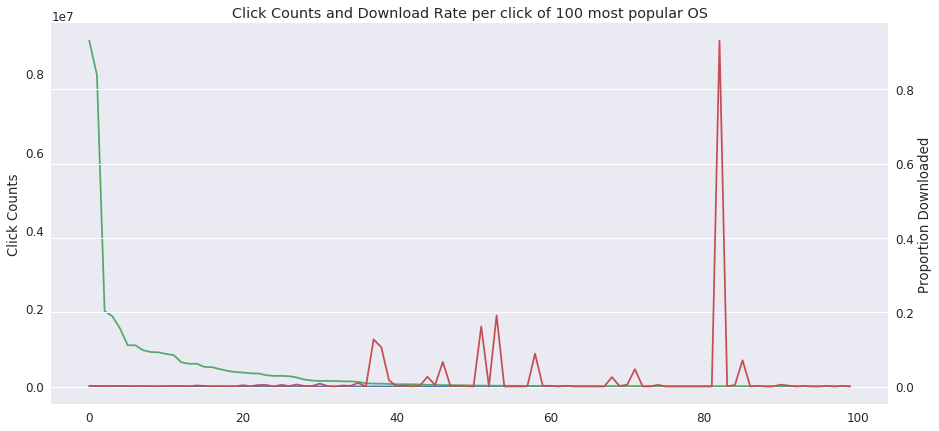

Proportion Downloaded over Click Counts of most popular OS
    os  click_count  prop_downloaded
0   19      8835683         0.001795
1   13      7959600         0.001550
2   17      1928144         0.001140
3   18      1795760         0.001341
4   22      1483024         0.001761
..  ..          ...              ...
15  14       500127         0.001500
16  41       493016         0.000771
17   1       443336         0.001056
18  12       400507         0.000774
19  23       368471         0.000700

[20 rows x 3 columns]


In [13]:
proportion = df[['os', 'is_attributed']].groupby('os', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = df[['os', 'is_attributed']].groupby('os', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='os', how='left')
merge.columns = ['os', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(figsize = (15,7), secondary_y='prop_downloaded', legend=None)
plt.title('Click Counts and Download Rate per click of 100 most popular OS')
ax.set(ylabel='Click Counts')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Proportion Downloaded over Click Counts of most popular OS')
print(merge[:20])

Note que o que ocorre com os sistemas operacionais mais populares é semelhante ao caso dos aplicativos.

## Click Counts e Download Rate por Device

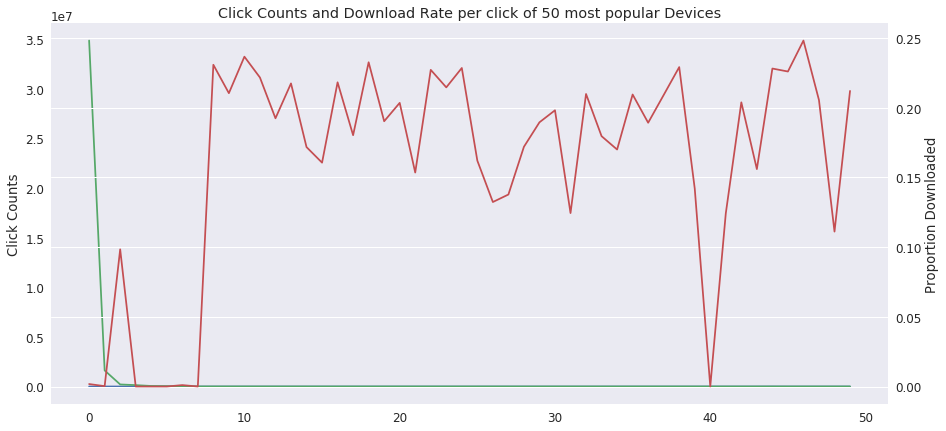

Proportion Downloaded over Click Counts of most popular Devices
    device  click_count  prop_downloaded
0        1     34866572         0.001759
1        2      1619994         0.000256
2        0       206986         0.098398
3     3032       138638         0.000007
4     3543        53493         0.000000
..     ...          ...              ...
15     154          791         0.160556
16      67          770         0.218182
17      37          699         0.180258
18      88          688         0.232558
19     114          657         0.190259

[20 rows x 3 columns]


In [14]:
proportion = df[['device', 'is_attributed']].groupby('device', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = df[['device', 'is_attributed']].groupby('device', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='device', how='left')
merge.columns = ['device', 'click_count', 'prop_downloaded']

ax = merge[:50].plot(figsize = (15,7), secondary_y='prop_downloaded', legend=None)
plt.title('Click Counts and Download Rate per click of 50 most popular Devices')
ax.set(ylabel='Click Counts')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Proportion Downloaded over Click Counts of most popular Devices')
print(merge[:20])

Esse gráfico deixa evidente que `device` é desproporcionalmente distribuído, onde o `device` 1 é responsável por grande parte dos clicks. O resto é semelhantes aos dois casos anteriores.

## Click Counts e Download Rate por Channel

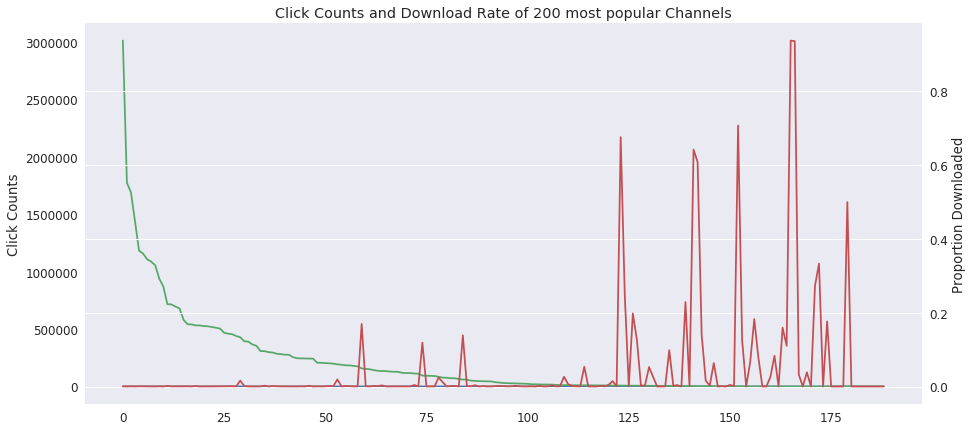

Proportion Downloaded over Click Counts of most popular Channels
    channel  click_count  prop_downloaded
0       280      3013408         0.000274
1       245      1774483         0.000097
2       107      1691099         0.000508
3       477      1439610         0.000166
4       134      1183603         0.000609
..      ...          ...              ...
15      439       580536         0.000475
16      489       542229         0.000516
17      128       540764         0.000205
18      466       532107         0.001145
19      135       531953         0.000109

[20 rows x 3 columns]


In [15]:
proportion = df[['channel', 'is_attributed']].groupby('channel', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = df[['channel', 'is_attributed']].groupby('channel', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='channel', how='left')
merge.columns = ['channel', 'click_count', 'prop_downloaded']

ax = merge[:200].plot(figsize = (15,7), secondary_y='prop_downloaded', legend=None)
plt.title('Click Counts and Download Rate of 200 most popular Channels')
ax.set(ylabel='Click Counts')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Proportion Downloaded over Click Counts of most popular Channels')
print(merge[:20])

Neste caso a contagem de clicks está menos concentrada do que nos anteriores, e há alguns picos de taxa de download por click em `channels` que ainda tem uma quantidade razoável de clicks.

## Tempo

In [16]:
df['day'] = df.click_time.dt.day.astype('uint16')
df['hour'] = df.click_time.dt.hour.astype('uint16')

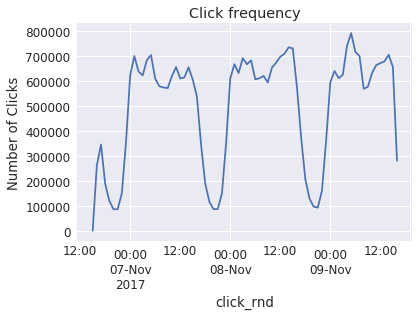

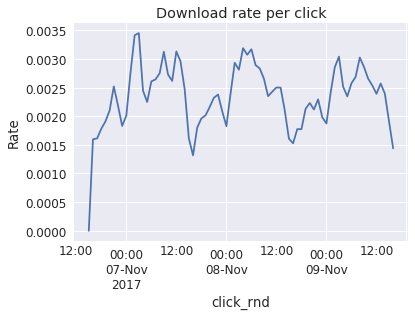

In [17]:
df['click_rnd']=df['click_time'].dt.round('H') 

df[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=True).count().plot(legend=None)
plt.title('Click frequency');
plt.ylabel('Number of Clicks');

df[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=True).mean().plot(legend=None)
plt.title('Download rate per click');
plt.ylabel('Rate');

Primeiramente, analisemos ao longo dos dias a frequência de clicks. Parece haver uma sazonalidade ao longo dos dias que depende dos horários, e parece que o dia em si não é um fator importante para a frequência de clicks.  Isso nos motiva a juntar os dados diários e investigar essa frequência por hora. 
A taxa de download por click está sempre abaixo de 0,35% e também parece demonstrar sazonalidade.

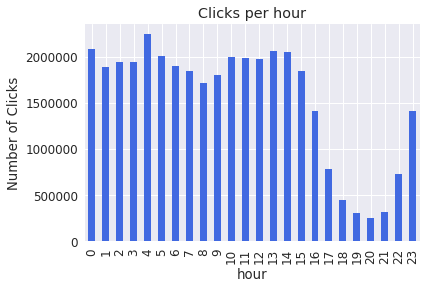

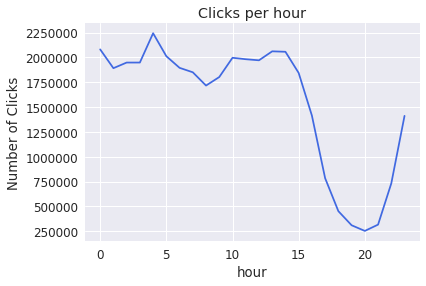

In [18]:
df[['hour','is_attributed']].groupby(['hour'], as_index=True).count().plot(kind='bar', color='royalblue', legend=None)
plt.title('Clicks per hour');
plt.ylabel('Number of Clicks');

df[['hour','is_attributed']].groupby(['hour'], as_index=True).count().plot(color='royalblue', legend=None)
plt.title('Clicks per hour');
plt.ylabel('Number of Clicks');

Note agora que temos uma noção bem clara do que ocorre ao longo do dia. Temos uma queda acentuada dos clicks a partir das 16h, que volta a subir após as 20h, e só atinge os patamares anteriores após a meia noite. 

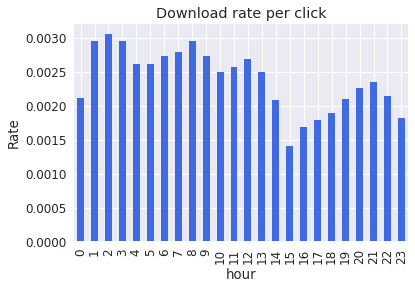

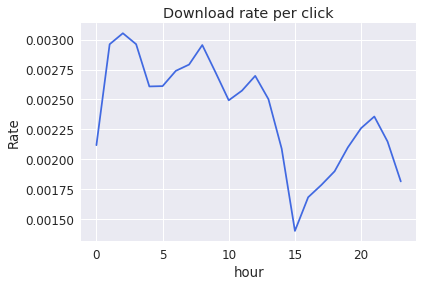

In [19]:
df[['hour','is_attributed']].groupby(['hour'], as_index=True).mean().plot(kind='bar', color='royalblue', legend=None)
plt.title('Download rate per click');
plt.ylabel('Rate');

df[['hour','is_attributed']].groupby(['hour'], as_index=True).mean().plot( color='royalblue', legend=None)
plt.title('Download rate per click');
plt.ylabel('Rate');

Podemos observar que a taxa de download por click tem uma queda às 15h, e é maior na parte da madrugada. Para tentar identificar alguma relação entre os últimos gráficos, vamos plotá-los juntos.

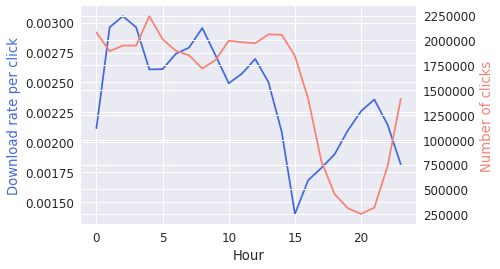

In [27]:
group = df[['hour','is_attributed']].groupby(['hour'], as_index=False).mean()
x = group['hour']
ymean = group['is_attributed']
group = df[['hour','is_attributed']].groupby(['hour'], as_index=False).count()
ycount = group['is_attributed']


fig = plt.figure()
host = fig.add_subplot(111)

par1 = host.twinx()

host.set_xlabel("Hour")
host.set_ylabel("Download rate per click")
par1.set_ylabel("Number of clicks")


color1 = 'royalblue'
color2 = 'salmon'

p1, = host.plot(x, ymean, color=color1,label="Download rate per click")
p2, = par1.plot(x, ycount, color=color2, label="Number of clicks")

lns = [p1, p2]


host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

plt.savefig("pyplot_multiple_y-axis.png", bbox_inches='tight')

Podemos ver um movimento semelhante na parte da tarde de queda dos dois gráficos, porém para o resto das horas parece haver na verdade uma relação inversa entre essas duas variáveis. Isso pode ser um indício de que quando o número de clicks é baixo, estamos observando mais os potenciais downloaders e menos os bots que geram clicks fraudulentos, o que pode fazer com que a taxa de download por click seja maior (análogo para quando o número de clicks é alto e a taxa de download por click é baixa).

## Top downloaders por categoria



Vamos analisar agora quem gera mais downloads em cada categoria.

Text(0.5,1,'Top 20 bigest downloader by IP')

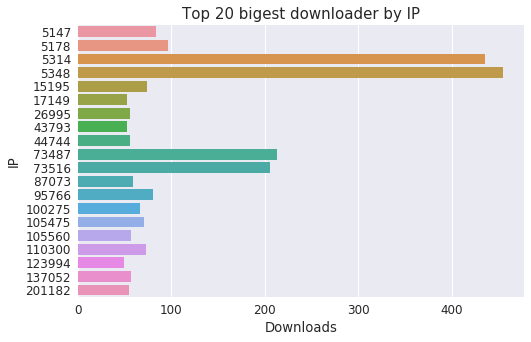

In [21]:
DL_by_IP = df.groupby('ip').is_attributed.sum()

data_to_plot = DL_by_IP.nlargest(20).reset_index()
data_to_plot.columns=('IP', 'Downloads')
data_to_plot.sort_values('Downloads', ascending = False)
plt.figure(figsize = (8,5))
sns.barplot(x = data_to_plot['Downloads'], y = data_to_plot['IP'], orient = 'h')
plt.title('Top 20 bigest downloader by IP', fontsize = 15)

Text(0.5,1,'Top 20 bigest downloader by app')

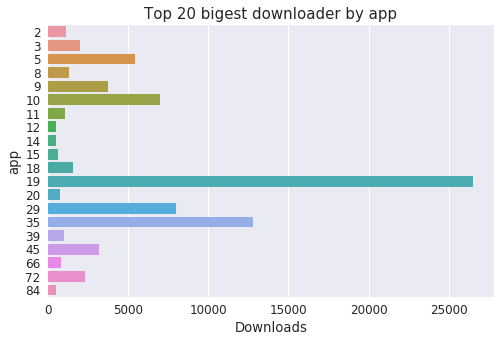

In [22]:
DL_by_ap = df.groupby('app').is_attributed.sum()

data_to_plot = DL_by_ap.nlargest(20).reset_index()
data_to_plot.columns=('app', 'Downloads')
data_to_plot.sort_values('Downloads', ascending = False)
plt.figure(figsize = (8,5))
sns.barplot(x = data_to_plot['Downloads'], y = data_to_plot['app'], orient = 'h')
plt.title('Top 20 bigest downloader by app', fontsize = 15)

Text(0.5,1,'Top 20 bigest downloader by device')

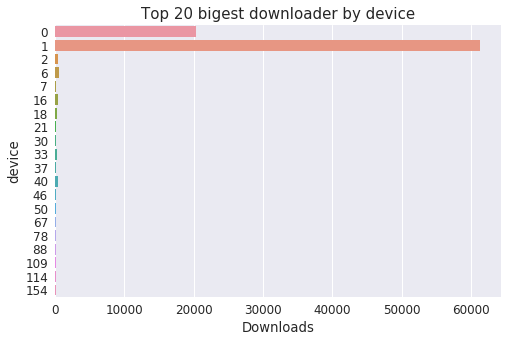

In [23]:
DL_by_dv = df.groupby('device').is_attributed.sum()

data_to_plot = DL_by_dv.nlargest(20).reset_index()
data_to_plot.columns=('device', 'Downloads')
data_to_plot.sort_values('Downloads', ascending = False)
plt.figure(figsize = (8,5))
sns.barplot(x = data_to_plot['Downloads'], y = data_to_plot['device'], orient = 'h')
plt.title('Top 20 bigest downloader by device', fontsize = 15)

Text(0.5,1,'Top 20 bigest downloader by OS')

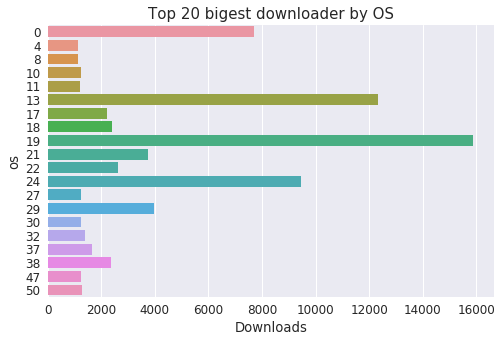

In [24]:
DL_by_os = df.groupby('os').is_attributed.sum()

data_to_plot = DL_by_os.nlargest(20).reset_index()
data_to_plot.columns=('os', 'Downloads')
data_to_plot.sort_values('Downloads', ascending = False)
plt.figure(figsize = (8,5))
sns.barplot(x = data_to_plot['Downloads'], y = data_to_plot['os'], orient = 'h')
plt.title('Top 20 bigest downloader by OS', fontsize = 15)

Text(0.5,1,'Top 20 bigest downloader by channel')

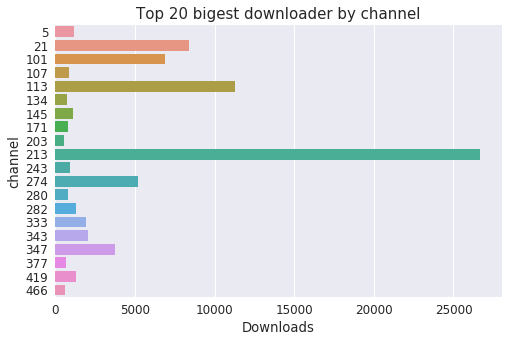

In [25]:
DL_by_cl = df.groupby('channel').is_attributed.sum()

data_to_plot = DL_by_cl.nlargest(20).reset_index()
data_to_plot.columns=('channel', 'Downloads')
data_to_plot.sort_values('Downloads', ascending = False)
plt.figure(figsize = (8,5))
sns.barplot(x = data_to_plot['Downloads'], y = data_to_plot['channel'], orient = 'h')
plt.title('Top 20 bigest downloader by channel', fontsize = 15)

Note que os downloads são relativamente concentrados em cada categoria, e em especial em `device` são quase completamente representados pelos `devices` 0 e 1. 

## Clusters

Também pode ser interessante uma análise com clusters para vermos se conseguimos mais alguma intuição dos dados. 

In [28]:
IP = df['ip'].value_counts()

IP_ready_to_merge = pd.DataFrame(IP).reset_index()
IP_ready_to_merge.columns=['ip', 'freq_ip']

IP_ready_to_merge['clicker_type'] = ''
IP_ready_to_merge.loc[IP_ready_to_merge['freq_ip'] <= 10, 'clicker_type'] = "low clicker"
IP_ready_to_merge.loc[(IP_ready_to_merge['freq_ip'] >= 10) & (IP_ready_to_merge['freq_ip'] < 300), 'clicker_type'] = "medium clicker"
IP_ready_to_merge.loc[(IP_ready_to_merge['freq_ip'] >= 300) & (IP_ready_to_merge['freq_ip'] < 30000), 'clicker_type'] = "high clicker"
IP_ready_to_merge.loc[IP_ready_to_merge['freq_ip'] >= 30000, 'clicker_type'] = "very high clicker"

df = pd.merge(df, IP_ready_to_merge, on ='ip')

Text(0,0.5,'')

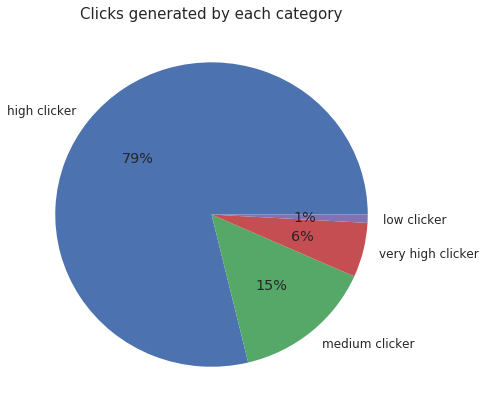

In [29]:
plt.figure(figsize = (7,7))
df['clicker_type'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title("Clicks generated by each category", fontsize =15)
plt.ylabel("")

O gráfico nos mostra que a maior parte dos clicks da amostra advém de high clickers.

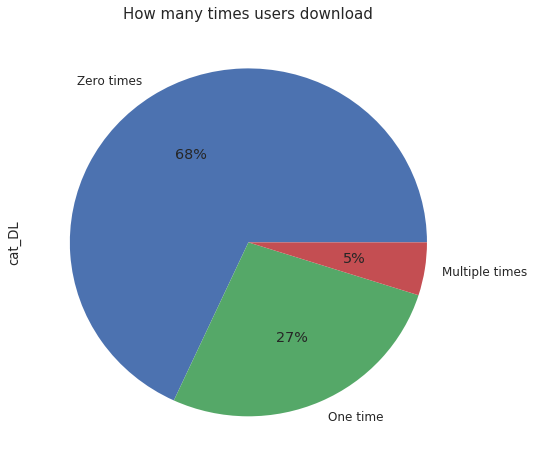

In [30]:
data_to_plot2 = pd.DataFrame(DL_by_IP).reset_index()

data_to_plot2["cat_DL"] = ''
data_to_plot2.loc[data_to_plot2['is_attributed'] == 0, "cat_DL"] = "Zero times"
data_to_plot2.loc[data_to_plot2['is_attributed'] == 1, "cat_DL"] = "One time"
data_to_plot2.loc[data_to_plot2['is_attributed'] > 1, "cat_DL"] = "Multiple times"

plt.figure(figsize=(8,8))
data_to_plot2["cat_DL"].value_counts().plot(kind = 'pie',autopct='%1.0f%%')
plt.title('How many times users download', fontsize=15)
plt.ytitle=''

A maior parte dos usuários não realiza o download, enquanto uma boa parte realiza apenas uma vez. Note que 5% realiza o download mais de uma vez, o que não é algo comum de se esperar de usuários normais.

Text(84,0.5,'Categories of downloaders')

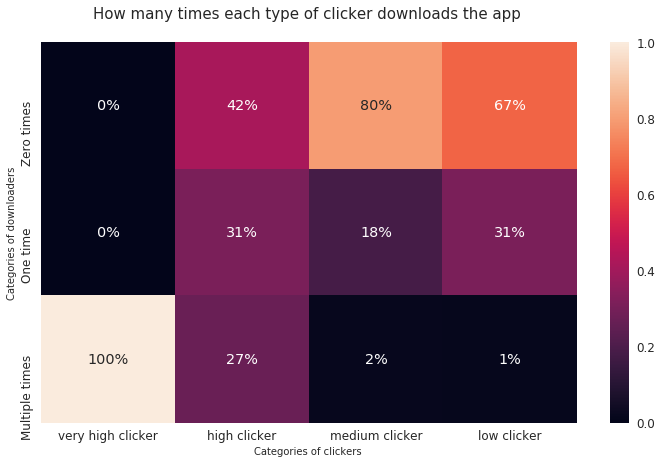

In [31]:
ip_level = pd.merge(IP_ready_to_merge, data_to_plot2, on='ip')
cross_tab = pd.crosstab(ip_level['cat_DL'], ip_level['clicker_type'], normalize='columns')

cross_tab.index = pd.CategoricalIndex(cross_tab.index, categories = ['Multiple times', 'One time', 'Zero times'])
cross_tab = cross_tab.sort_index(ascending = False)

cross_tab = cross_tab[['very high clicker', 'high clicker', 'medium clicker', 'low clicker']]

plt.figure(figsize = (12,7))
plt.title('How many times each type of clicker downloads the app \n', fontsize=15) 
sns.heatmap(cross_tab,annot=True, fmt='.0%')
plt.xlabel('Categories of clickers ', fontsize = 10)
plt.ylabel('Categories of downloaders', fontsize = 10)

Este gráfico nos esclarece que low e medium clickers (que devem ser usuários normais) muito raramente irão realizar o download mais de uma vez, ou baixam ou não baixam. Por outro lado, o very high clicker quase sempre realiza o download múltiplas vezes, o que indica que devem se tratar majoritariamente de bots. O high clicker fica no meio termo entre essas duas divisões.

## Importância das Features

Por fim, podemos usar um modelo simples de previsão para testar a importância das features de nossa amostra.

Novamente, por motivos computacionais vamos restringir mais nossa amostra, agora a 10% da amostra total.

In [32]:
df = df.sample(frac = 0.5)

In [33]:
# Clicks Count
df['n_ip'] = df.groupby('ip')['ip'].transform('count')

df['n_ip_os'] = df.groupby(['ip', 'os'])['ip'].transform('count')
df['n_ip_dev'] = df.groupby(['ip', 'device'])['ip'].transform('count')
df['n_ip_app'] = df.groupby(['ip', 'app'])['ip'].transform('count')

# Time 
df['day_hour'] = df['day'] * 100 + df['hour']

df = df.sort_values(by=['ip', 'click_time'])

df['ct_lag'] = df.groupby(['ip'])['click_time'].shift(1)
df['ct_lead'] = df.groupby(['ip'])['click_time'].shift(-1)

df['td_lag'] = df['click_time'] - df['ct_lag']
df['td_lead'] = df['ct_lead'] - df['click_time']

df['min_td'] = df[['td_lag', 'td_lead']].min(axis=1) / pd.Timedelta(hours=1)

df['min_td'].fillna(max(df.min_td), inplace = True)

df = df.drop(['ip', 'ct_lag', 'ct_lead', 'td_lag', 'td_lead', 'click_time', 'day', 'hour', 'click_rnd', 'clicker_type'], axis=1)

In [34]:
from sklearn.cross_validation import train_test_split
import lightgbm as lgb

df_train = df.sample(frac = 0.8)
df_valid = df.sample(frac = 0.2)

y_train = df_train.is_attributed.values
y_valid = df_valid.is_attributed.values

df_train = df_train.drop('is_attributed', axis=1)
df_valid = df_valid.drop('is_attributed', axis=1)

categorical = ['app', 'device', 'os', 'channel', 'day_hour']
features = [col for col in df_train.columns]

lgb_train = lgb.Dataset(df_train, y_train, feature_name = features, categorical_feature=categorical, free_raw_data=False)
lgb_valid = lgb.Dataset(df_valid, y_valid, feature_name = features, categorical_feature=categorical, free_raw_data=False)

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 7,
    'max_depth': 3,
    'min_child_samples': 100,  
    'max_bin': 100,  
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'scale_pos_weight': 99.74 
}

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [35]:
gbm = lgb.train(params,
               lgb_train,
               num_boost_round=500,
               valid_sets=lgb_valid,
               early_stopping_rounds=30,
               verbose_eval=False)
gbm.best_score

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


defaultdict(dict, {'valid_0': {'auc': 0.9808210405101264}})

In [36]:
pd.set_option('display.max_rows', 25)
pd.DataFrame({'feature': features, 'importance': gbm.feature_importance()}).sort_values(by='importance', ascending=False)

,feature,importance
3,channel,892
9,day_hour,679
2,os,561
0,app,476
8,n_ip_app,96
4,freq_ip,78
7,n_ip_dev,56
1,device,49
6,n_ip_os,40
10,min_td,38


O resultado nos mostra que, das features originais, `channel`, `os` e `app` são as mais importantes para prever `is_attributed`, enquanto `device` não é tão importante. Isso corrobora a intuição que derivamos dos gráficos de "Clicks and downloads by feature (%)", onde os gráficos de `channel`, `os` e `app` são mais informativos que o de `device`.
Além disso,  `day_hour` é a segunda variável que mais afeta o output do nosso modelo, confirmando a importância da análise temporal dos dados. 
Essas informações serão especialmente úteis quando formos fazer o modelo de previsão.